In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from nn_tools import Qfirst, Qfollowing, optimiers_list, one_epoch_layers, EarlyStoppingList
import torch.nn as nn
from learning_tools import peak_one, algo_p, algo_e, update, assess_models
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
def learning_algo(data,max_iter=100, nb_layers=5, epsilon=0.1,
                  include_early_stopping = True, min_es_list = [1e-2]*5, patience_es_list = [100]*5,
                  loss= nn.MSELoss(),batch_size=50, device='cpu'):

    #### Initialisation des variables ####
    D = [[torch.empty(0), torch.empty(0)] for _ in range(nb_layers)]  # Un dataset D par couche
    all_actions = list(range(36))  # 36 actions possibles
    Q_models = [Qfirst() if i == 0 else Qfollowing() for i in range(nb_layers)]
    losses=[]
    if include_early_stopping:
        early_stop_list = EarlyStoppingList(min_es_list, patience_es_list)
    
    #### Boucle sur les epochs ####
    for _ in tqdm(range(max_iter)):
        #### Augmentation du dataset ####
        bidding_history = np.zeros(36) # array de 5x36 pour enregistrer l'historique des enchères
        x1, x2, scores = peak_one(data)

        for j in range(nb_layers):
            C = np.zeros(36)  
            hand = x1 if (j+1) % 2 == 1 else x2  # main du joueur actuel

            #### Calcul des coûts des actions: policy evaluation ####
            for i, action in enumerate(all_actions):
                C[i] = algo_p(action,x1,x2,scores,bidding_history,Q_models,nb_layers)
            
            # state = main si première couche sinon state = main + enchère_précédente
            state = torch.tensor(hand, dtype=torch.float32) if j == 0 else torch.tensor(np.concatenate([hand, bidding_history]), dtype=torch.float32)
            D=update(D,state,C,j) #ajout de l'expérience dans le dataset D_j
            
            #### Exploration ####
            next_a = algo_e(Q_models[j], state, epsilon, all_actions)  # Sélection avec Q_j
            if next_a == len(bidding_history) - 1:  # si l'action est PASS
                break  
            bidding_history[next_a] = 1  # enregistrement de l'action choisie dans l'historique des enchères

        #### Entraînement des modèles Q ####
        opti_list=optimiers_list(Q_models)
        losses.append(one_epoch_layers(Q_models, D, opti_list,loss, batch_size, device))
        if include_early_stopping and early_stop_list.test_stop(losses[-1], [Q.state_dict() for Q in Q_models]):
            early_stop_list.set_best_weights(Q_models)
            break
    return Q_models, np.array([np.array(l) for l in losses])

In [ ]:
def plot_losses(losses, offset = 0):
    _, axs = plt.subplots(1,losses.shape[1], figsize = (4*losses.shape[1], 4))

    for k in range(losses.shape[1]):
        sns.lineplot(losses[offset:,k], ax=axs[k])
        axs[k].set_title(f"Loss {k}th layer")
    plt.tight_layout()
    plt.show()

In [3]:
data = pd.read_csv("data/slice0.csv", index_col = 0)

In [19]:
Q_models, losses = learning_algo(data, max_iter=100, min_es_list=[1e10]*5, patience_es_list= [10]*5)

 22%|██▏       | 22/100 [00:05<00:18,  4.17it/s]


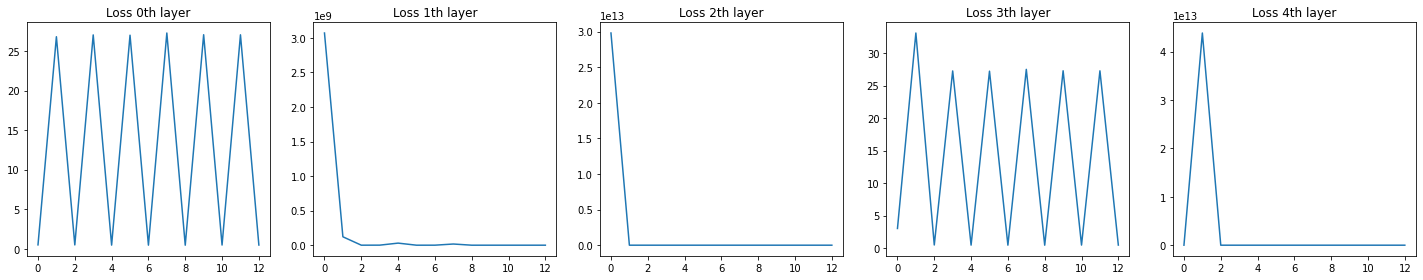

In [42]:
plot_losses(losses, offset=10)

In [ ]:
results = assess_models(Q_models, pd.read_csv("data/slice12.csv"))
results

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\RL-for-bridge-bidding\learning_tools.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(
c:\Users\Chardin Pierre\OneDrive - CentraleSupelec\Bureau\CS\3a\DL\RL-for-bridge-bidding\learning_tools.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
100%|██████████| 10000/10000 [00:51<00:00, 194.38it/s]
C:\Users\Chardin Pierre\AppData\Local\Temp\ipykernel_17576\3798397793.py:10: RuntimeWarning: inval

array([     nan,      nan,      nan,      nan, 0.686736])